In [123]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from gensim.models import KeyedVectors, Word2Vec
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
import pickle

from datasets import Dataset
from transformers import BertTokenizer, BertModel
import torch
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
import seaborn as sns

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/noble/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/noble/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df = pd.read_csv('final_dataset.csv')
df.head()

,video_text
0,Over in the ocean by the sand and the sun\nliv...
1,"Learn the English Alphabet, learn the letters ..."
2,"Sight words, sight words all around\nSight wor..."
3,"Sight words, sight words all around Sight word..."
4,Look out for bossy r Bossy r When you read you...


In [5]:
texts = df['video_text'].values
texts[:5]

array(['Over in the ocean by the sand and the sun\nlived a strong mommy turtle and her little turtle one "Paddle," said the mommy. "I paddle," said the one. So they paddled and they played by the sand\nand the sun. Over in the ocean colored green and blue lived\na dig daddy whale and his little whales two. "Dive," said the daddy. \'We dive," said the two. So they dove and they played in the the green\nand the blue. Over in the ocean way down in the deep lived\na proud grandma eel and her little eels three. "Slither," said the grandma. "We slither," said the three. So they slithered and they played way down\nin the deep. Over in the ocean on the sandy ocean floor\nlived a friendly grandpa crab and his little crabbies four. "Snap," said the grandpa. "We snap," said the four. So they snapped and they played on the sandy\nocean floor. Over in the ocean where the waves splash high\nlived a sweet auntie seal and her little seals five. "Jump," said the auntie. "We jump," said the five. So the

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   video_text  943 non-null    object
dtypes: object(1)
memory usage: 7.5+ KB
None


In [7]:
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

In [8]:
def clean_text(text):
    text = text.lower()  # Lowercase
    text = text.replace('\n', ' ') # Remove newline characters and replace with space
    text = re.sub(r"n't", ' not', text)
    text = re.sub(r"'re", ' are', text)
    text = re.sub(r"'s", ' is', text)
    text = re.sub(r"'d", ' would', text)
    text = re.sub(r"'ll", ' will', text)
    text = re.sub(r"'t", ' not', text)
    text = re.sub(r"'ve", ' have', text)
    text = re.sub(r"'m", ' am', text)
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces

    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop] # Remove stop words and lemmatize
    cleaned_text = ' '.join(tokens) # Join the tokens back into a string

    return cleaned_text

In [9]:
df['clean_transcripts'] = df['video_text'].apply(clean_text)
df.head()

,video_text,clean_transcripts
0,Over in the ocean by the sand and the sun\nliv...,ocean sand sun live strong mommy turtle little...
1,"Learn the English Alphabet, learn the letters ...",learn english alphabet learn letter english al...
2,"Sight words, sight words all around\nSight wor...",sight word sight word sight word sight word le...
3,"Sight words, sight words all around Sight word...",sight word sight word sight word sight word le...
4,Look out for bossy r Bossy r When you read you...,look bossy r bossy r read star look bossy r bo...


In [10]:
clean_texts = df['clean_transcripts'].values
clean_texts[:5]

array(['ocean sand sun live strong mommy turtle little turtle paddle say mommy paddle say paddle play sand sun ocean color green blue live dig daddy whale little whale dive say daddy dive say dive play green blue ocean way deep live proud grandma eel little eel slither say grandma slither say slither play way deep ocean sandy ocean floor live friendly grandpa crab little crabbie snap say grandpa snap say snap play sandy ocean floor ocean wave splash high live sweet auntie seal little seal jump say auntie jump say jump play wave splash high ocean near small island tip live hungry uncle shark little shark hunt say uncle hunt say hunt play small island tip ocean sun shine heaven live kind stepmommy sailfish little sailfish seven sail say mommy sail say seven sail play sun shine heaven ocean kelp forest sway live silly stepdaddy otter little otter wiggle say daddy wiggle say wiggle play kelp forest sway ocean swift seagull fly live greatgrandma dolphin little dolphin swim say grandma swim 

In [109]:
text_combined = ' '.join(df['clean_transcripts'])
text_combined

'ocean sand sun live strong mommy turtle little turtle paddle say mommy paddle say paddle play sand sun ocean color green blue live dig daddy whale little whale dive say daddy dive say dive play green blue ocean way deep live proud grandma eel little eel slither say grandma slither say slither play way deep ocean sandy ocean floor live friendly grandpa crab little crabbie snap say grandpa snap say snap play sandy ocean floor ocean wave splash high live sweet auntie seal little seal jump say auntie jump say jump play wave splash high ocean near small island tip live hungry uncle shark little shark hunt say uncle hunt say hunt play small island tip ocean sun shine heaven live kind stepmommy sailfish little sailfish seven sail say mommy sail say seven sail play sun shine heaven ocean kelp forest sway live silly stepdaddy otter little otter wiggle say daddy wiggle say wiggle play kelp forest sway ocean swift seagull fly live greatgrandma dolphin little dolphin swim say grandma swim say swa

In [12]:
# Generate Word Cloud without specifying font_path

#wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

#plt.figure(figsize=(10, 5))
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis('off')
#plt.show()


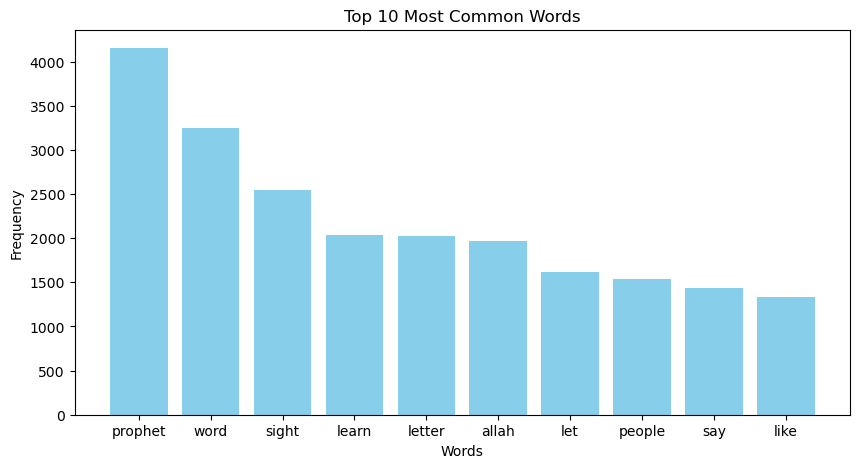

In [13]:
# Word Frequency
words = text_combined.split()
word_freq = Counter(words)
most_common_words = word_freq.most_common(10)
# Extract words and their frequencies for plotting
words = [item[0] for item in most_common_words]
frequencies = [item[1] for item in most_common_words]

# Plot Word Frequency
plt.figure(figsize=(10, 5))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words')
plt.show()

In [116]:
from sklearn.feature_extraction.text import CountVectorizer
text_combined = df['clean_transcripts'].tolist()


vectorizer = CountVectorizer(ngram_range=(2, 3))
X = vectorizer.fit_transform(text_combined)
n_grams = vectorizer.get_feature_names_out()
counts = X.sum(axis=0).A1

ngram_df = pd.DataFrame({'n_gram': n_grams, 'count': counts})
ngram_df = ngram_df.sort_values(by='count', ascending=False)
ngram_df


,n_gram,count
142306,sight word,2511
4990,allah swt,1065
84615,learn sight,841
84616,learn sight word,840
85815,let learn,774
...,...,...
182808,zzebra animal alphabet,1
50375,feel shoulder,1
50376,feel shoulder shoulder,1
50378,feel sick die,1


In [121]:
from textblob import TextBlob

df['sentiment'] = df['clean_transcripts'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['sentiment_category'] = pd.cut(df['sentiment'], bins=[-1, -0.1, 0.1, 1], labels=['Negative', 'Neutral', 'Positive'])
len(df[df['sentiment_category']=="Negative"])


32

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

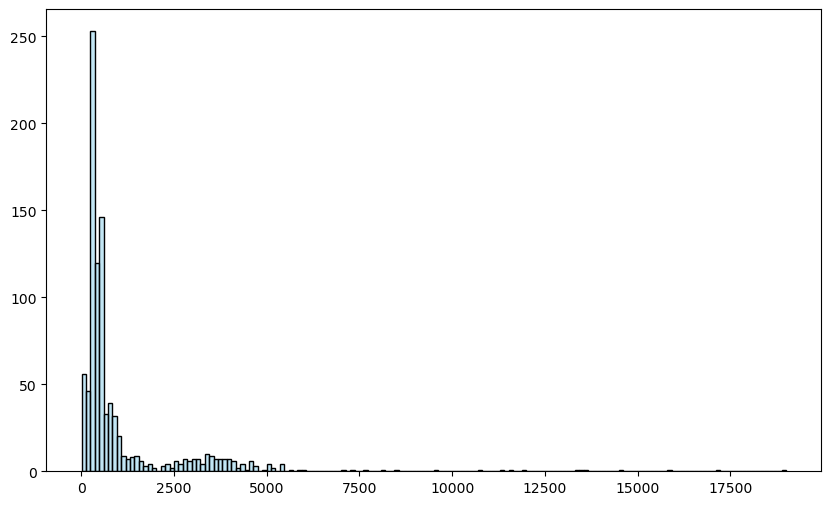

In [125]:
# 2. Length of Transcripts
df['transcript_length'] = df['clean_transcripts'].apply(len)

# Plotting the distribution of transcript lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['transcript_length'], kde=True, color='skyblue')
plt.title('Distribution of Transcript Lengths')
plt.xlabel('Transcript Length')
plt.ylabel('Frequency')
plt.show()


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

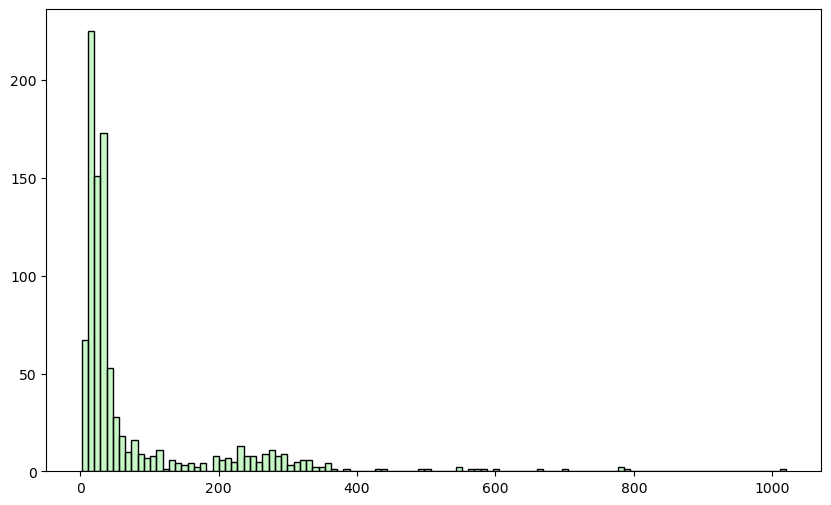

In [127]:
# 3. Unique Words
df['unique_words'] = df['clean_transcripts'].apply(lambda x: len(set(x.split())))

# Plotting the unique words per transcript
plt.figure(figsize=(10, 6))
sns.histplot(df['unique_words'], kde=True, color='lightgreen')
plt.title('Distribution of Unique Words Per Transcript')
plt.xlabel('Number of Unique Words')
plt.ylabel('Frequency')
plt.show()

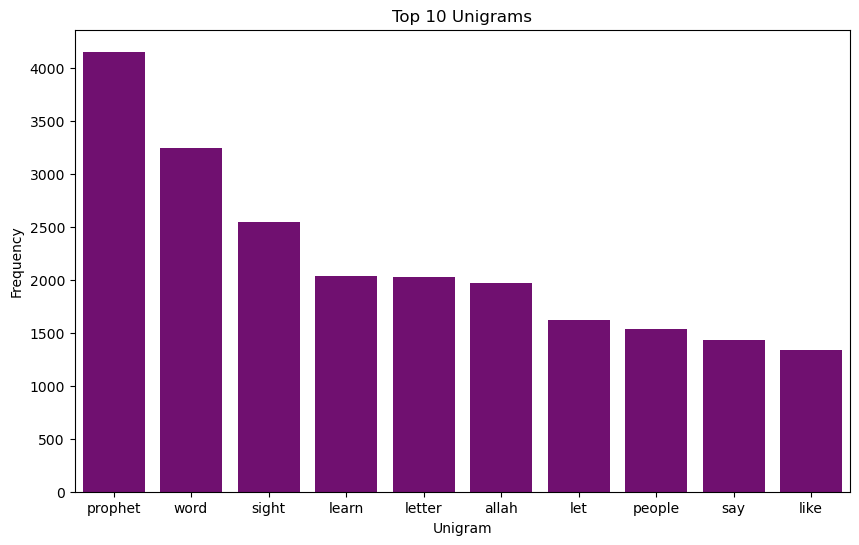

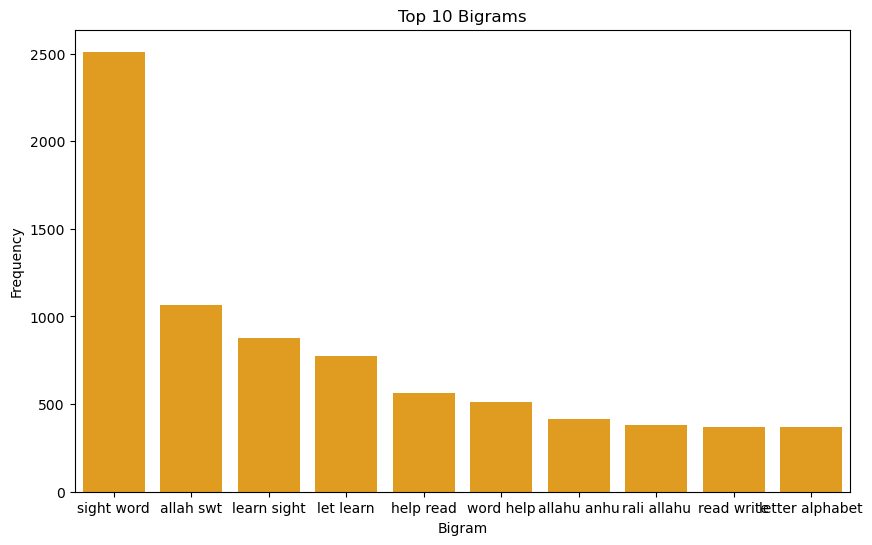

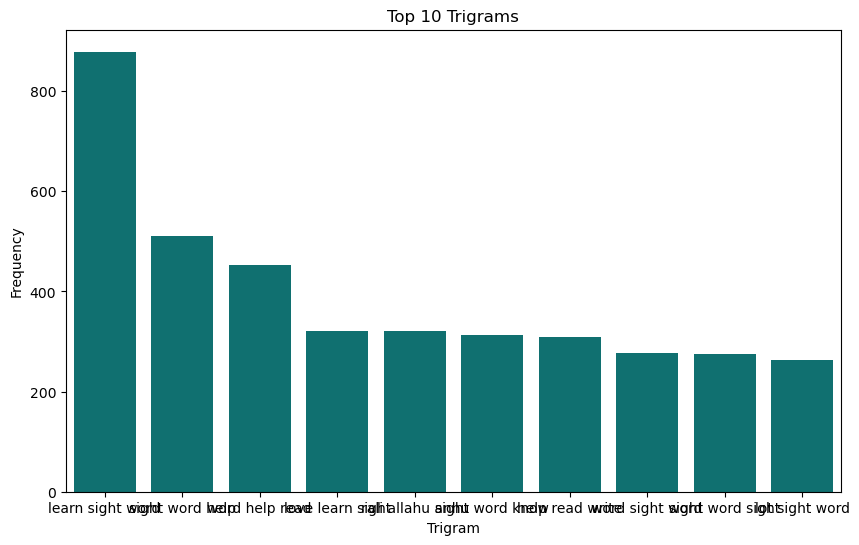

In [128]:



# 4. Visualization

# Bar Plots: Frequency of Words, Bigrams, Trigrams
def plot_ngrams(texts, n=1):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(texts)
    bag_of_words = vec.transform(texts)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:10]

unigrams = plot_ngrams(df['clean_transcripts'], 1)
bigrams = plot_ngrams(df['clean_transcripts'], 2)
trigrams = plot_ngrams(df['clean_transcripts'], 3)

# Unigrams
plt.figure(figsize=(10, 6))
sns.barplot(x=[word for word, freq in unigrams], y=[freq for word, freq in unigrams], color='purple')
plt.title('Top 10 Unigrams')
plt.xlabel('Unigram')
plt.ylabel('Frequency')
plt.show()

# Bigrams
plt.figure(figsize=(10, 6))
sns.barplot(x=[word for word, freq in bigrams], y=[freq for word, freq in bigrams], color='orange')
plt.title('Top 10 Bigrams')
plt.xlabel('Bigram')
plt.ylabel('Frequency')
plt.show()

# Trigrams
plt.figure(figsize=(10, 6))
sns.barplot(x=[word for word, freq in trigrams], y=[freq for word, freq in trigrams], color='teal')
plt.title('Top 10 Trigrams')
plt.xlabel('Trigram')
plt.ylabel('Frequency')
plt.show()



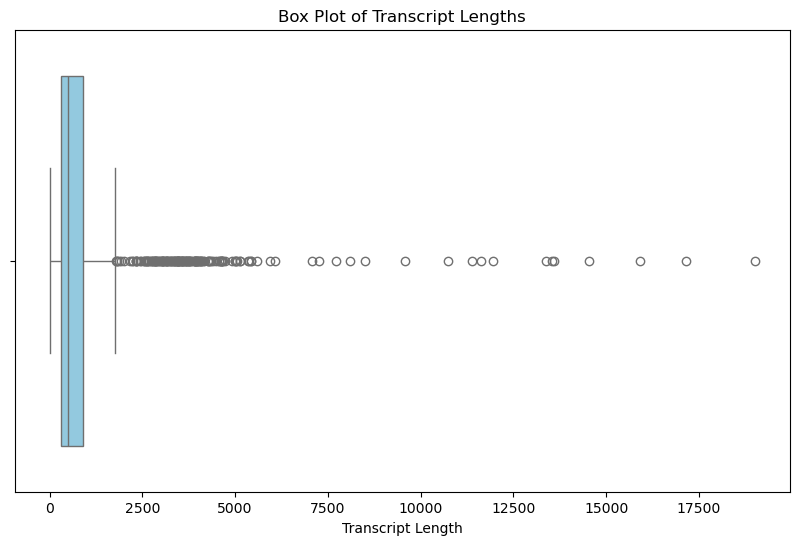

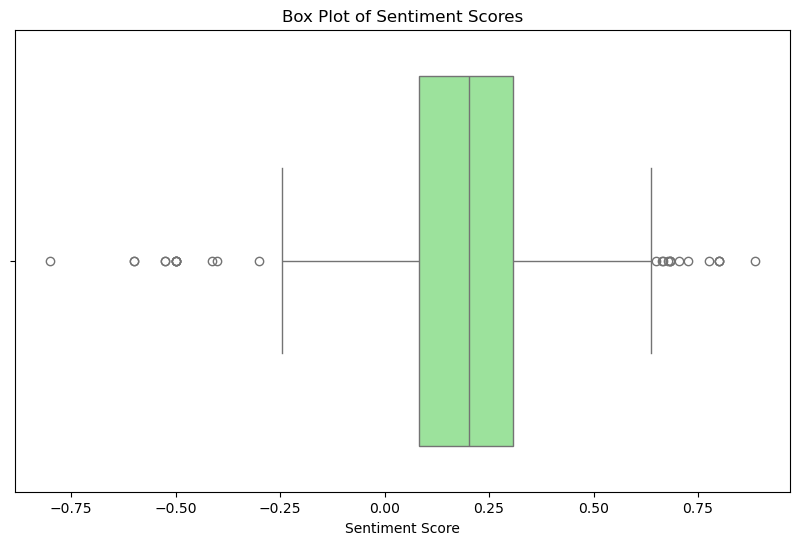

In [129]:
# Box Plots: Distribution of Transcript Lengths or Sentiment Scores
df['sentiment'] = df['clean_transcripts'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Box Plot for Transcript Lengths
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['transcript_length'], color='skyblue')
plt.title('Box Plot of Transcript Lengths')
plt.xlabel('Transcript Length')
plt.show()

# Box Plot for Sentiment Scores
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['sentiment'], color='lightgreen')
plt.title('Box Plot of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.show()


In [21]:
df_cleaned = pd.DataFrame(df.clean_transcripts)
df_cleaned.head()

,clean_transcripts
0,ocean sand sun live strong mommy turtle little...
1,learn english alphabet learn letter english al...
2,sight word sight word sight word sight word le...
3,sight word sight word sight word sight word le...
4,look bossy r bossy r read star look bossy r bo...


In [22]:
dataset = Dataset.from_pandas(df_cleaned)
dataset

Dataset({
    features: ['clean_transcripts'],
    num_rows: 943
})

In [27]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/home/noble/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:  43%|####2     | 189M/440M [00:00<?, ?B/s]

In [29]:
def tokenize_function(examples):
    return tokenizer(examples['clean_transcripts'], padding='max_length', truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/943 [00:00<?, ? examples/s]

In [30]:
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512) # The max_length to be updated.
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

In [31]:
embeddings = [get_embeddings(text) for text in df_cleaned['clean_transcripts']]
embeddings = torch.tensor(embeddings)

/tmp/ipykernel_10014/2189644434.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  embeddings = torch.tensor(embeddings)


In [32]:
embeddings_2d = embeddings.view(embeddings.size(0), -1).numpy()

In [63]:
isolation_forest = IsolationForest(contamination=0.1)
isolation_forest.fit(embeddings_2d)

anomalies = isolation_forest.predict(embeddings_2d)
df_cleaned['anomaly'] = anomalies

In [64]:
a = df_cleaned[df_cleaned['anomaly']==-1].values
a

array([['love rhyme love rhyme let rhyme good time word rhyme help think word rhyme right loud cat sit _ _ _ _ _ _ _ _ _ _ _ _ dog log _ _ _ _ _ _ _ _ _ _ _ big wig _ _ _ _ _ _ _ _ _ _ _ _ ham sam _ _ _ _ _ _ _ _ _ fan _ _ _ _ _ _ _ _ _ _ _ _ net pet _ _ _ _ _ _ _ _ _ _ _ _ love rhyme love rhyme let rhyme good time tot get _ _ _ _ _ _ _ _ _ _ _ _ mug tug _ _ _ _ _ _ _ _ _ _ _ tap map _ _ _ _ _ _ _ _ _ _ _ rub scrub _ _ _ _ _ _ _ _ _ _ sip dip _ _ _ _ _ _ _ _ _ _ _ _ _ hut rut _ _ _ _ _ _ _ _ _ _ _ _ _ love rhyme love rhyme let rhyme good time bed feed _ _ _ _ _ _ _ _ _ _ _ bit fit _ _ _ _ _ _ _ _ _ _ _ _ _ dad glad _ _ _ _ _ _ _ _ _ _ fun run _ _ _ _ _ _ _ _ _ _ _ bag tag _ _ _ _ _ _ _ _ _ _ _ shop drop _ _ _ _ _ _ _ _ love rhyme love rhyme let rhyme good time love rhyme love rhyme let rhyme good time let rhyme',
        -1],
       ['good morning good day today sunday day good kind helpful respect listen learn care day good morning good day today sunday',
        -1],
       ['cone nb

In [65]:
with open('isolation_forest_model.pkl', 'wb') as f:
    pickle.dump(isolation_forest, f)

In [101]:
# Preprocess the subtitle text
non_appropriate_subtitle = """
"Hey, did you see that new movie? It was so violent, people were getting shot left and right.",
"Yeah, and the language! They were swearing all the time, like dropping f-bombs in every sentence.",
"And there were scenes with drug use, people doing lines of cocaine right on the screen.",
"Totally not appropriate for kids, with all that sex and nudity. Just disgusting."
"""
non_appropriate_subtitle_1 = """

You are so stupid and useless. Nobody cares about you, just die.
Shut up and get lost, you idiot. I don't want to see your face again.
"""

non_appropriate_subtitle_2 = """
I am the one causing this chaos. My hands are stained with blood, and I revel in it.
This power, this control over life and death, it's intoxicating. I am unstoppable.
"""
cleaned_subtitle = clean_text(non_appropriate_subtitle)
print("Cleaned Text:", cleaned_subtitle)

# Tokenize the cleaned text
tokenized_text = tokenizer(cleaned_subtitle, padding='max_length', truncation=True, return_tensors='pt')
print("Tokenized Text:", tokenized_text)

# Generate embeddings
with torch.no_grad():
    outputs = model(**tokenized_text)
    embeddings = outputs.last_hidden_state.mean(dim=1)

print("Embeddings:", embeddings)

# Load your trained Isolation Forest model
# Assuming the model is saved as 'isolation_forest_model.pkl'

with open('isolation_forest_model.pkl', 'rb') as f:
    isolation_forest = pickle.load(f)

# Predict anomalies
anomaly_prediction = isolation_forest.predict(embeddings.numpy())
print("Anomaly Prediction:", anomaly_prediction)

# Interpret the results
if anomaly_prediction[0] == -1:
    print("The subtitle text is classified as non-appropriate.")
else:
    print("The subtitle text is classified as appropriate.")

Cleaned Text: hey new movie violent people getting shoot leave right yeah language swear time like drop fbomb sentence scene drug use people line cocaine right screen totally appropriate kid sex nudity disgusting
Tokenized Text: {'input_ids': tensor([[  101,  4931,  2047,  3185,  6355,  2111,  2893,  5607,  2681,  2157,
          3398,  2653,  8415,  2051,  2066,  4530,  1042,  5092, 14905,  6251,
          3496,  4319,  2224,  2111,  2240, 16034,  2157,  3898,  6135,  6413,
          4845,  3348, 16371, 25469, 19424,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,   

********************************

In [102]:
# Instantiate the LOF model
lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.1)  # Adjust hyperparameters as needed

# Fit the model to your data
anomaly_prediction_lof = lof_model.fit_predict(embeddings_2d)

# Anomaly predictions (-1 indicates anomaly, 1 indicates normal)
print("Anomaly Prediction (LOF):", anomaly_prediction_lof)


Anomaly Prediction (LOF): [ 1  1 -1  1  1  1  1  1  1 -1  1  1  1 -1  1 -1 -1  1 -1  1  1  1  1  1
  1 -1  1  1  1  1 -1 -1 -1  1 -1  1  1  1 -1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1 -1
  1  1 -1  1  1 -1  1  1  1  1  1 -1  1  1  1  1 -1  1 -1  1 -1  1  1  1
 -1  1 -1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1 -1 -1  1  1 -1 -1  1
 -1 -1 -1  1 -1  1 -1  1 -1 -1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 

In [103]:
with open('local_outlier_factor.pkl', 'wb') as f:
    pickle.dump(lof_model, f)

In [104]:
with open('isolation_forest_model.pkl', 'rb') as f:
    lof_model = pickle.load(f)

# Predict anomalies
anomaly_prediction = lof_model.predict(embeddings.numpy())
print("Anomaly Prediction:", anomaly_prediction)

# Interpret the results
if anomaly_prediction[0] == -1:
    print("The subtitle text is classified as non-appropriate.")
else:
    print("The subtitle text is classified as appropriate.")

Anomaly Prediction: [1]
The subtitle text is classified as appropriate.


In [105]:
# Instantiate the One-Class SVM model
svm_model = OneClassSVM(nu=0.1)  # Adjust nu based on your dataset

# Fit the model to your data
svm_model.fit(embeddings_2d)

# Predict anomalies
anomaly_prediction_svm = svm_model.predict(embeddings_2d)

# Anomaly predictions (-1 indicates anomaly, 1 indicates normal)
print("Anomaly Prediction (One-Class SVM):", anomaly_prediction_svm)


Anomaly Prediction (One-Class SVM): [ 1  1 -1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1  1  1  1  1  1  1  1 -1  1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1 -1
  1 -1 -1  1 -1 -1  1 -1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1 -1  1  1  1  1  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1
 -1  1  1 -1  1

In [106]:
with open('one_class_svm.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

In [107]:
with open('isolation_forest_model.pkl', 'rb') as f:
    svm_model = pickle.load(f)

# Predict anomalies
anomaly_prediction = svm_model.predict(embeddings.numpy())
print("Anomaly Prediction:", anomaly_prediction)

# Interpret the results
if anomaly_prediction[0] == -1:
    print("The subtitle text is classified as non-appropriate.")
else:
    print("The subtitle text is classified as appropriate.")

Anomaly Prediction: [1]
The subtitle text is classified as appropriate.
